Gefundene Zeitreihen mit Kriterien: 264
Top 5 GROW_IDs: ['GROW-80939064354', 'GROW-80952817519', 'GROW-80940657465', 'GROW-80953817666', 'GROW-80931816834']


'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.'M' is deprecated and will be removed in a future version, please use 'ME' instead.

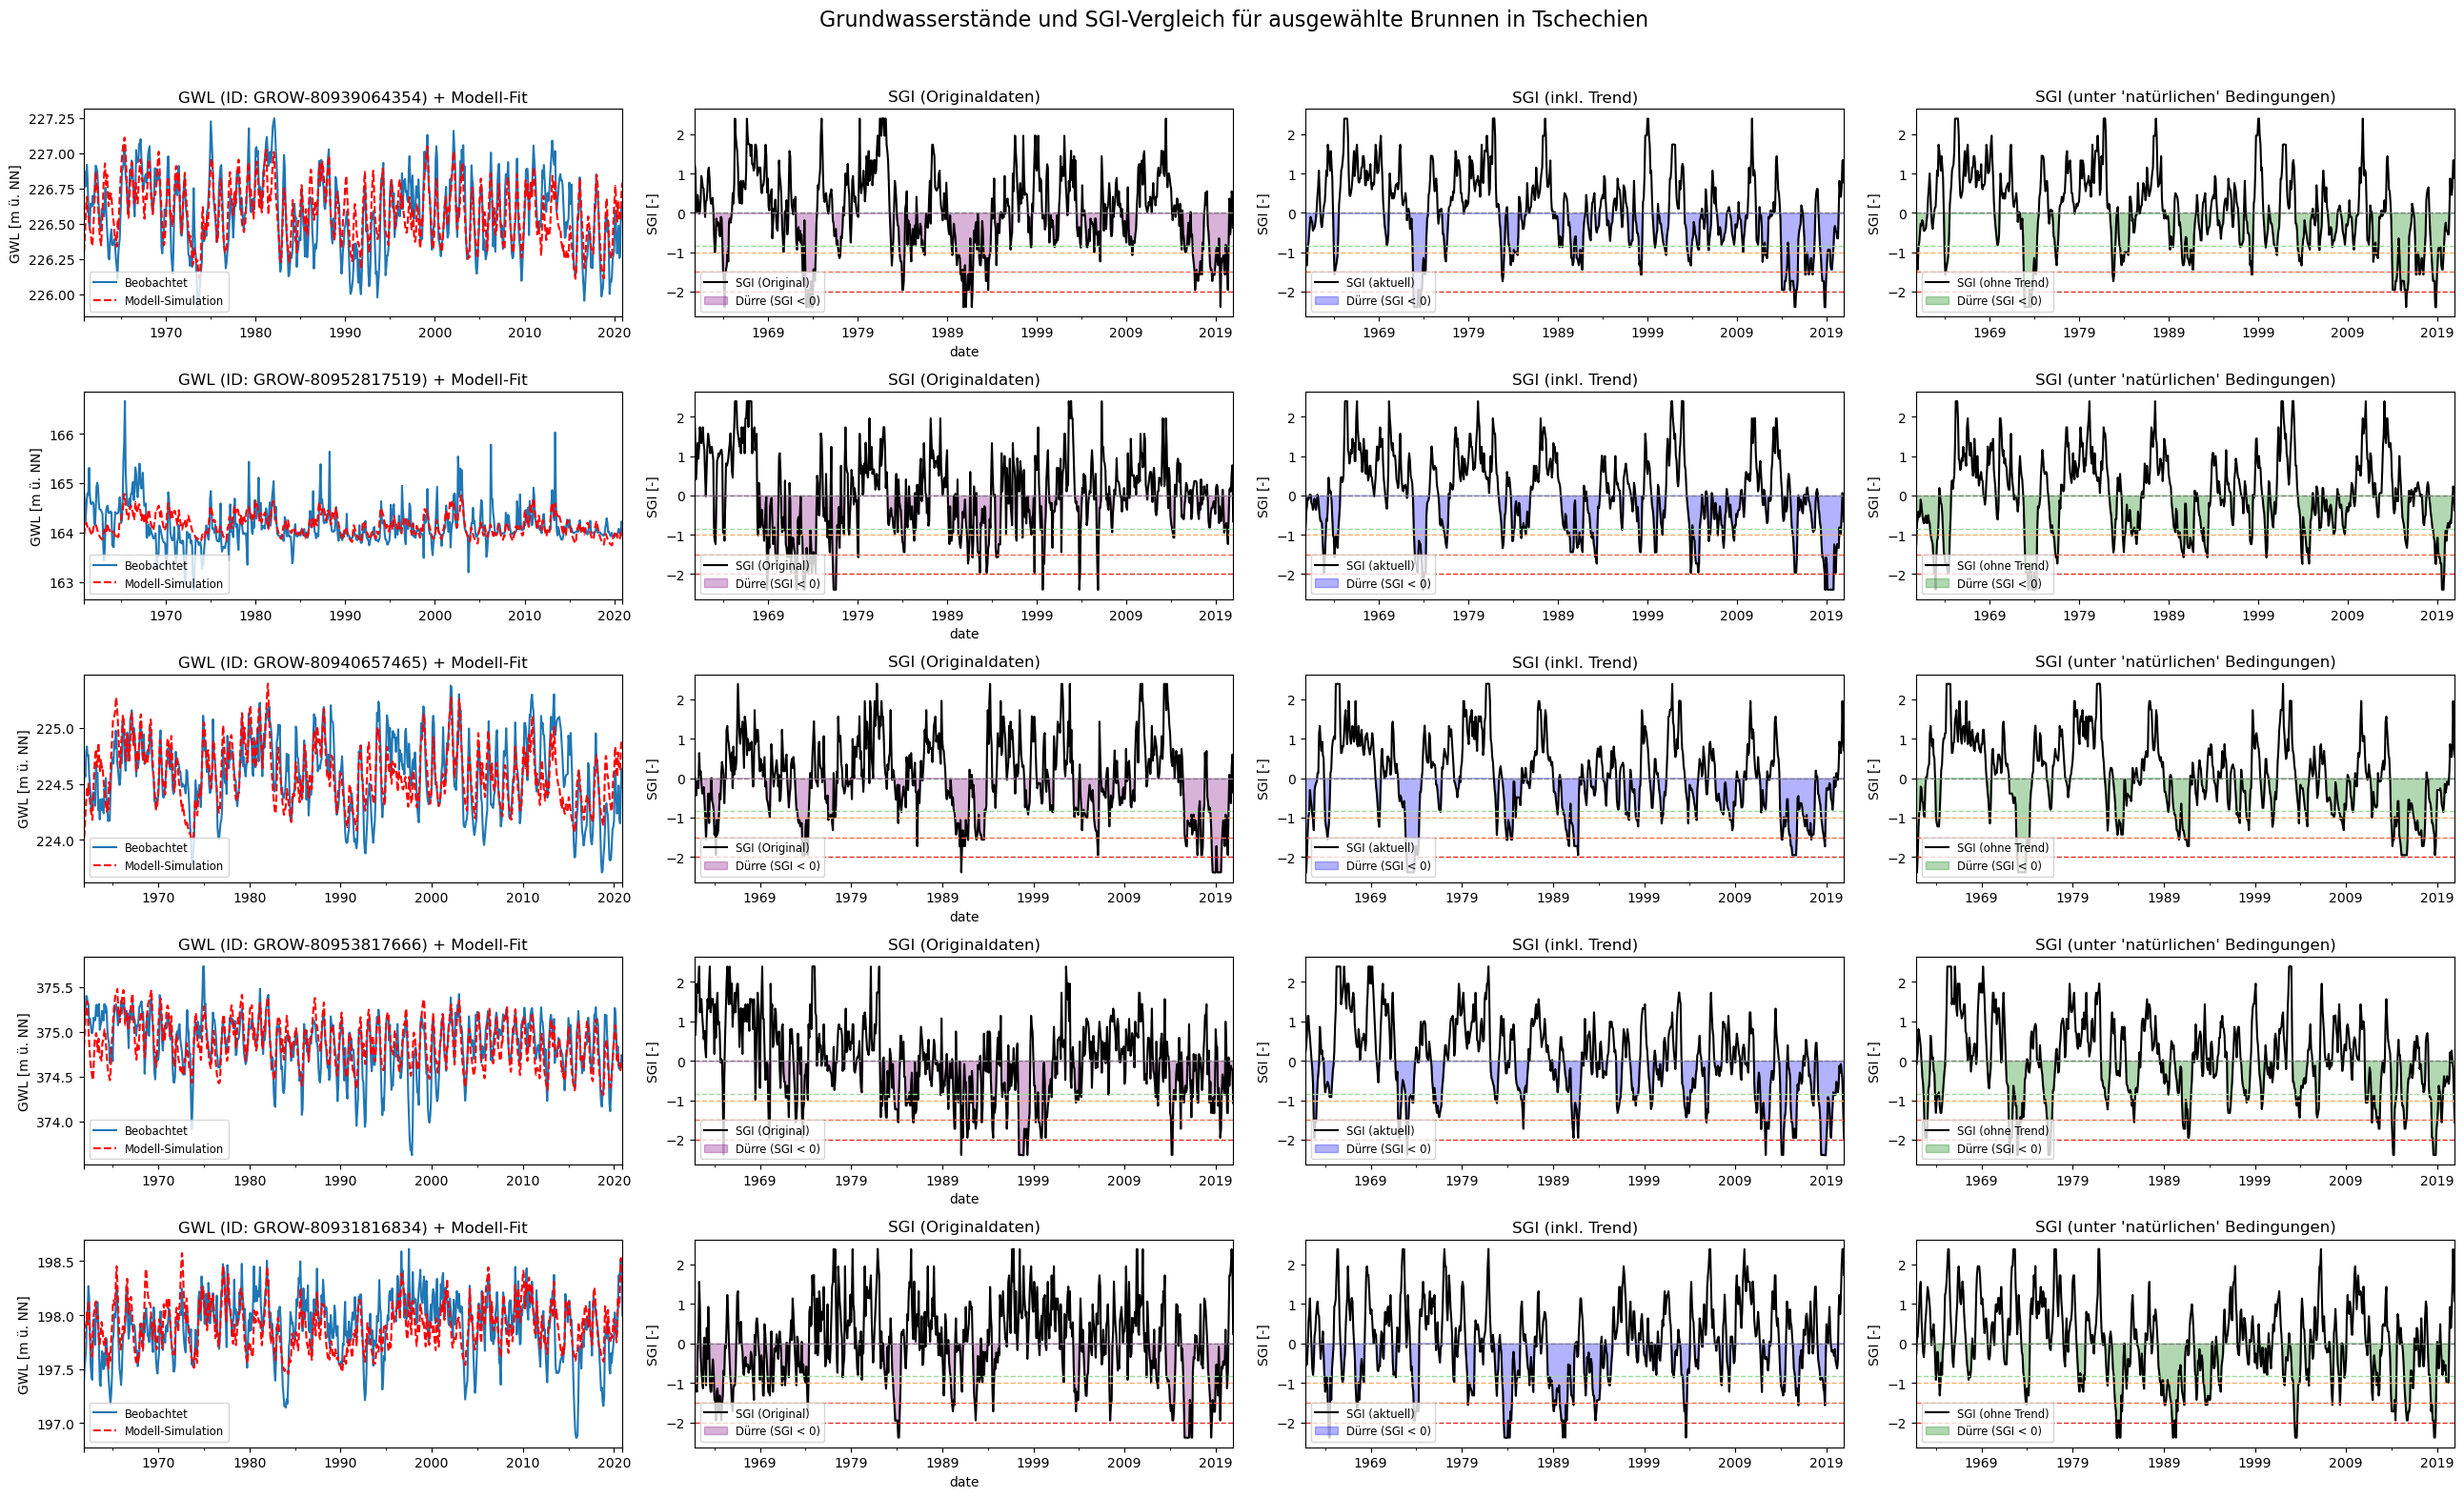

In [24]:
# 1. Bibliotheken importieren
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import pyarrow.dataset as ds

# 2. Loglevel reduzieren
ps.set_log_level("ERROR")

# 3. Attribute-Datei laden (metadata über die Zeitreihen)
attr = pd.read_parquet("Daten/grow_attributes.parquet")

# 4. Tschechische GROW_IDs mit den gewünschten Kriterien auswählen
attr_filtered = attr[
    (attr["country"] == "CZE") &
    (attr["length_years"] >= 30) &
    (attr["gap_fraction"] == 0.0) &
    (pd.to_datetime(attr["ending_date"]) >= pd.Timestamp("2023-12-01"))
]

# Anzahl passender Zeitreihen anzeigen
print(f"Gefundene Zeitreihen mit Kriterien: {len(attr_filtered)}")

if attr_filtered.empty:
    raise ValueError("Keine passende Zeitreihe für CZ mit ≥30 Jahren, ohne Gaps, bis ≥2023 gefunden.")

# Top 5 GROW_IDs mit längster Laufzeit auswählen
top5_ids = attr_filtered.sort_values("length_years", ascending=False).head(5)["GROW_ID"].tolist()
print("Top 5 GROW_IDs:", top5_ids)

# 5. GROW_IDs bereinigen für Arrow-Filter
cz_ids = attr_filtered["GROW_ID"].dropna()
cz_ids = cz_ids[cz_ids.str.strip() != ""].tolist()

# 6. Parquet-Dataset selektiv laden
dataset = ds.dataset("Daten/grow_timeseries.parquet", format="parquet")
table = dataset.to_table(filter=ds.field("GROW_ID").isin(top5_ids),
                         columns=["GROW_ID", "date", "groundwater_level_m_asl",
                                  "precipitation_gpcc_mm_year-1",
                                  "potential_evapotranspiration_era5_mm_year-1"])
ts = table.to_pandas()

# Konvertieren Sie die Niederschlags- und Evapotranspirationsdaten von mm/Jahr in mm/Monat
ts["precipitation_gpcc_mm_month-1"] = ts["precipitation_gpcc_mm_year-1"] / 12
ts["potential_evapotranspiration_era5_mm_month-1"] = ts["potential_evapotranspiration_era5_mm_year-1"] / 12

# 7. Plot vorbereiten
# Jetzt 4 Spalten: 1x GWL, 1x SGI (Original), 1x SGI (inkl. Trend), 1x SGI (ohne Trend)
fig, axes = plt.subplots(5, 4, figsize=(26, 16), sharex=False) # Angepasste Spaltenzahl und Figure-Größe
fig.suptitle("Grundwasserstände und SGI-Vergleich für ausgewählte Brunnen in Tschechien", fontsize=16)

# Definition der Dürreschwellen und Farben
thresholds = [-0.84, -1.00, -1.50, -2.00]
colors = ["#a1d99b", "#fdae6b", "#fb6a4a", "#de2d26"]

# 8. Schleife über Top 5 GROW_IDs
for i, grow_id in enumerate(top5_ids):
    # Zeitreihe für den aktuellen Brunnen extrahieren
    brunnen_df = ts[ts["GROW_ID"] == grow_id].copy()
    
    serie = brunnen_df[["date", "groundwater_level_m_asl"]].dropna()
    serie.set_index("date", inplace=True)
    serie.index = pd.to_datetime(serie.index)
    serie = serie.squeeze()
    serie.name = f"GWL [{grow_id}]"

    # Niederschlags- und Evapotranspirationsdaten extrahieren und vorbereiten
    rain = brunnen_df[["date", "precipitation_gpcc_mm_month-1"]].dropna()
    rain.set_index("date", inplace=True)
    rain.index = pd.to_datetime(rain.index)
    rain = rain.squeeze()
    rain.name = f"Rain [{grow_id}]"

    evap = brunnen_df[["date", "potential_evapotranspiration_era5_mm_month-1"]].dropna()
    evap.set_index("date", inplace=True)
    evap.index = pd.to_datetime(evap.index)
    evap = evap.squeeze()
    evap.name = f"Evap [{grow_id}]"

    # Sicherstellen, dass rain und evap den gleichen Datumsbereich wie serie abdecken
    common_index = serie.index.intersection(rain.index).intersection(evap.index)
    if common_index.empty or len(common_index) < 12: # Mindestens 12 Monate für SGI
        print(f"Skipping {grow_id}: No sufficient common time period for modeling.")
        # Wenn wir hier abbrechen, stellen wir sicher, dass die Achsen für diesen Brunnen leer bleiben
        for ax in axes[i]:
            ax.set_visible(False)
        continue
    
    serie_filtered = serie[common_index] # Verwenden Sie eine gefilterte Version für Modellierung
    rain_filtered = rain[common_index]
    evap_filtered = evap[common_index]

    # Wenn nach der Filterung die Serie leer ist, überspringen
    if serie_filtered.empty or rain_filtered.empty or evap_filtered.empty:
        print(f"Skipping {grow_id}: Time series became empty after aligning indices.")
        for ax in axes[i]:
            ax.set_visible(False)
        continue

    # --- SGI-Berechnung DIREKT aus den Originaldaten ---
    sgi_original = ps.stats.sgi(serie_filtered)

    try:
        # --- Pastas-Modellierung mit Trend ---
        ml = ps.Model(serie_filtered, name=f"Brunnen_{grow_id}_Modell")
        ml.add_noisemodel(ps.ArNoiseModel())

        rch_model = ps.RechargeModel(rain_filtered, evap_filtered, recharge=ps.rch.FlexModel(), rfunc=ps.Exponential(), name="rch")
        ml.add_stressmodel(rch_model)

        trend_start_date = serie_filtered.index.min().strftime('%Y-%m-%d')
        trend_end_date = serie_filtered.index.max().strftime('%Y-%m-%d')
        linear_trend = ps.LinearTrend(trend_start_date, trend_end_date, name="linear_trend")
        ml.add_stressmodel(linear_trend)
        
        ml.solve(tmin=trend_start_date, report=False)

        # Simulation der Zeitreihen
        sim_full = ml.simulate(tmin=trend_start_date)
        sim_natural = ml.get_contribution("rch", tmin=trend_start_date) + ml.get_parameters("constant")

        # SGI-Berechnung für beide Simulationen
        sgi_full = ps.stats.sgi(sim_full.resample("M").mean())
        sgi_natural = ps.stats.sgi(sim_natural.resample("M").mean())

    except Exception as e:
        print(f"  Fehler bei der Modellierung für {grow_id}: {e}. Plots für SGI (inkl. Trend) und SGI (natürlich) bleiben leer.")
        # Falls Modellierung fehlschlägt, setzen wir die modellbasierten SGI-Werte auf None oder eine leere Serie
        sgi_full = pd.Series(dtype=float)
        sgi_natural = pd.Series(dtype=float)

    # --- Plots für die aktuelle Reihe (ax1 für GWL, ax2 für SGI (Original), ax3 für SGI (inkl. Trend), ax4 für SGI (ohne Trend))
    ax1, ax2, ax3, ax4 = axes[i]

    # Plot 1: Grundwasserstand (GWL) + Modell-Fit
    serie_filtered.plot(ax=ax1, label="Beobachtet")
    if not sim_full.empty: # Nur plotten, wenn Simulation erfolgreich war
        sim_full.plot(ax=ax1, linestyle='--', color='red', label="Modell-Simulation")
    ax1.set_ylabel("GWL [m ü. NN]")
    ax1.set_title(f"GWL (ID: {grow_id}) + Modell-Fit")
    ax1.legend(loc="lower left", fontsize="small")

    # Plot 2: SGI (Originaldaten)
    sgi_original.plot(ax=ax2, color="black", label="SGI (Original)")
    ax2.axhline(0, linestyle="--", color="gray", linewidth=1)
    for t, c in zip(thresholds, colors):
        ax2.axhline(t, linestyle="--", color=c, linewidth=1)
    droughts_original = sgi_original.copy()
    droughts_original[droughts_original > 0] = 0
    ax2.fill_between(sgi_original.index, 0, droughts_original, color="purple", alpha=0.3, label="Dürre (SGI < 0)") # Neue Farbe
    ax2.set_ylabel("SGI [-]")
    ax2.set_title("SGI (Originaldaten)")
    ax2.legend(loc="lower left", fontsize="small")

    # Plot 3: SGI (aktuell, mit Trend)
    if not sgi_full.empty:
        sgi_full.plot(ax=ax3, color="black", label="SGI (aktuell)")
        ax3.axhline(0, linestyle="--", color="gray", linewidth=1)
        for t, c in zip(thresholds, colors):
            ax3.axhline(t, linestyle="--", color=c, linewidth=1)
        droughts_full = sgi_full.copy()
        droughts_full[droughts_full > 0] = 0
        ax3.fill_between(sgi_full.index, 0, droughts_full, color="blue", alpha=0.3, label="Dürre (SGI < 0)")
        ax3.set_ylabel("SGI [-]")
        ax3.set_title("SGI (inkl. Trend)")
        ax3.legend(loc="lower left", fontsize="small")
    else:
        ax3.set_title("SGI (inkl. Trend) - Modellierungsfehler")
        ax3.set_visible(False) # Achse ausblenden, wenn kein Plot möglich

    # Plot 4: SGI (ohne Trend)
    if not sgi_natural.empty:
        sgi_natural.plot(ax=ax4, color="black", label="SGI (ohne Trend)")
        ax4.axhline(0, linestyle="--", color="gray", linewidth=1)
        for t, c in zip(thresholds, colors):
            ax4.axhline(t, linestyle="--", color=c, linewidth=1)
        droughts_natural = sgi_natural.copy()
        droughts_natural[droughts_natural > 0] = 0
        ax4.fill_between(sgi_natural.index, 0, droughts_natural, color="green", alpha=0.3, label="Dürre (SGI < 0)")
        ax4.set_ylabel("SGI [-]")
        ax4.set_title("SGI (unter 'natürlichen' Bedingungen)")
        ax4.legend(loc="lower left", fontsize="small")
    else:
        ax4.set_title("SGI (natürlich) - Modellierungsfehler")
        ax4.set_visible(False) # Achse ausblenden, wenn kein Plot möglich


# Gesamtlayout anpassen und anzeigen
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()